In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io 
import time
import random
import torch
import torch.nn as nn

np.random.seed(2024)
torch.manual_seed(2024)
if torch.cuda.is_available():  
    device = torch.device("cuda:1")
else:  
    device = torch.device("cpu") 

torch.__version__

'2.0.1'

In [32]:
class FCN(nn.Module):
    "Define a fully connected neural network"
    
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        super().__init__()
        activation = nn.Tanh   
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_input, N_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_hidden, N_hidden),
                            activation()]) for _ in range(N_layers-1)])
        self.fce = nn.Linear(N_hidden, N_output)
        
    def forward(self, x):
        x1 = self.fcs(x)
        x2 = self.fch(x1)
        x3 = self.fce(x2)
        return x3

def train(model, x_f, z_f, x_u, z_u, y_f, velmodelf, px0f, pz0f, T0f, velmodel_u, px0_u, pz0_u, T0_u, epochs):
    lr = 0.003
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    Loss_f = []
    loss_F=[]
    loss_U=[]
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        u1 = torch.stack((x_p, z_p), axis = -1)
        u1 = model(u1)
        u = u1.reshape(-1)
        dudx = torch.autograd.grad(u, x_p, grad_outputs = torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        dudz = torch.autograd.grad(u, z_p, grad_outputs = torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        f = (T0_u*dudx + u*px0_u)**2 + (T0_u*dudz + u*pz0_u)**2 - 1.0/velmodel_u**2
        loss_u = f.pow(2).mean()
#         loss_f = (stack_h(model,x_f, z_f)[:,0]*T0f+y_f).pow(2).mean()
        
        loss_f1 = torch.stack([x_f, z_f], axis=-1)
        loss_f = (model(loss_f1)[:,0]*T0f+y_f).pow(2).mean()

        print('loss_f and loss_u:',loss_f, loss_u)

        Loss = loss_u + loss_f
        Loss_f.append(Loss.item())
        loss_F.append(loss_f.item())
        loss_U.append(loss_u.item())
        Loss.backward()
        optimizer.step()
        if epoch % 1 == 0:
            print(f"Epoch: {epoch}/{epochs}, Loss: {Loss.item()}")
    return model, Loss_f, loss_F, loss_U

In [33]:
#Model specifications

v0 = 2.; # Velocity at the origin of the model
vergrad = 0.5; # Vertical gradient
horgrad = 0.; # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;


# Point-source location
sz = 1.0; sx = 1.0;

# Number of training points
num_tr_pts = 2500


# Creating grid, calculating refrence traveltimes, and prepare list of grid points for training (X_star)

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size


Z,X = np.meshgrid(z,x,indexing='ij')
print(X.shape)

# Preparing velocity model
vs = v0 + vergrad*sz + horgrad*sx # Velocity at the source location
velmodel = vs + vergrad*(Z-sz) + horgrad*(X-sx);

# Traveltime solution
if vergrad==0 and horgrad==0: 
  # For homogeneous velocity model
  T_data = np.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # For velocity gradient model
  T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)


X_star = [Z.reshape(-1,1), X.reshape(-1,1)] # Grid points for prediction 

selected_pts = np.random.choice(np.arange(Z.size),num_tr_pts,replace=False)
Zf = Z.reshape(-1,1)[selected_pts]
Zf = np.append(Zf,sz)
Xf = X.reshape(-1,1)[selected_pts]
Xf = np.append(Xf,sx)


X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)] # Grid points for training
print(len(X_star), len(X_starf))

(101, 101)
2 2


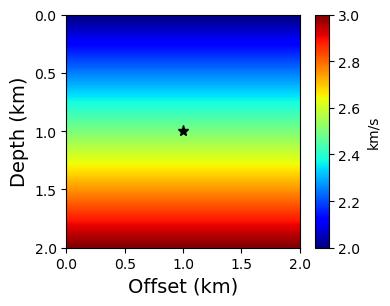

In [34]:

# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))
ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig("./figs/velmodel.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/velmodel.png", format='png', bbox_inches="tight", dpi=300)

In [35]:
# Analytical solution for the known traveltime part
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location
print(int(round(sz/deltaz)), int(round(sz/deltaz)), vel)

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; # the travel time T0 for each point in the grid
print(T0.shape, T0)

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0) # Calculates the x-component(horizontal) of the vector 
print(px0.shape, px0)

pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0) # Calculates the y-component (vertical) of the vector 
print(pz0.shape, pz0)

true_tau = np.divide(T_data, T0, out=np.zeros_like(T0), where=T0!=0)
print(true_tau.shape, true_tau)

50 50 2.5
(101, 101) [[0.56568542 0.56005714 0.55448715 ... 0.55448715 0.56005714 0.56568542]
 [0.56005714 0.55437172 0.54874402 ... 0.54874402 0.55437172 0.56005714]
 [0.55448715 0.54874402 0.54305801 ... 0.54305801 0.54874402 0.55448715]
 ...
 [0.55448715 0.54874402 0.54305801 ... 0.54305801 0.54874402 0.55448715]
 [0.56005714 0.55437172 0.54874402 ... 0.54874402 0.55437172 0.56005714]
 [0.56568542 0.56005714 0.55448715 ... 0.55448715 0.56005714 0.56568542]]
(101, 101) [[-0.28284271 -0.27997143 -0.27701273 ...  0.27701273  0.27997143
   0.28284271]
 [-0.28568514 -0.28284271 -0.27991193 ...  0.27991193  0.28284271
   0.28568514]
 [-0.28855493 -0.28574343 -0.28284271 ...  0.28284271  0.28574343
   0.28855493]
 ...
 [-0.28855493 -0.28574343 -0.28284271 ...  0.28284271  0.28574343
   0.28855493]
 [-0.28568514 -0.28284271 -0.27991193 ...  0.27991193  0.28284271
   0.28568514]
 [-0.28284271 -0.27997143 -0.27701273 ...  0.27701273  0.27997143
   0.28284271]]
(101, 101) [[-0.28284271 -0.2856

In [36]:
# Appending source values
velmodelf = velmodel.reshape(-1,1)[selected_pts]; velmodelf = np.append(velmodelf,vs)# selects the 2500 points from velmodel and appends the velocity at source location
px0f = px0.reshape(-1,1)[selected_pts]; px0f = np.append(px0f,0.) # selects the 2500 points from px0 and appends the value at source location
pz0f = pz0.reshape(-1,1)[selected_pts]; pz0f = np.append(pz0f,0.) # selects the 2500 points from pz0 and appends the value at source location
T0f = T0.reshape(-1,1)[selected_pts]; T0f = np.append(T0f,0.) # selects the 2500 points from T0 and appends the value at source location

velmodelf = torch.Tensor(velmodelf).float()
px0f = torch.Tensor(px0f).float()
pz0f = torch.Tensor(pz0f).float()
T0f = torch.Tensor(T0f).float()
# T_true = torch.Tensor(T_true).float()

In [37]:
xx_1 = X_starf[0][:,0]
xx_2 = X_starf[1][:,0]
xx_1 = torch.tensor(xx_1, requires_grad=True).float()
xx_2 = torch.tensor(xx_2, requires_grad=True).float()
xx_1.to(device)
xx_2.to(device)
print(xx_1.shape, xx_2.shape)

x_data=torch.stack([xx_1,xx_2]).T
T_true = T_data.reshape(-1,1)[selected_pts]; T_true = np.append(T_true,0.)
y_data = T_true
y_data = torch.Tensor(y_data)
print(type(x_data), x_data.shape, x_data)
print(y_data.shape)

torch.Size([2501]) torch.Size([2501])
<class 'torch.Tensor'> torch.Size([2501, 2]) tensor([[0.7800, 1.7000],
        [1.7600, 1.0200],
        [1.8200, 0.6800],
        ...,
        [0.3400, 1.4600],
        [0.2200, 0.3400],
        [1.0000, 1.0000]], grad_fn=<PermuteBackward0>)
torch.Size([2501])


In [38]:
X1 = X.reshape(-1)
Z1 = Z.reshape(-1)
velmodel_p = velmodel.reshape(-1)
px0_u1 = px0.reshape(-1)
pz0_u1 = pz0.reshape(-1)
T0_u1 = T0.reshape(-1)
z_u_npf = Zf.reshape(-1,1)
x_u_npf = Xf.reshape(-1,1)
y_data=T_true

x_p = torch.tensor(X1, requires_grad=True).reshape(X1.shape[0]).float()
z_p = torch.tensor(Z1, requires_grad=True).reshape(Z1.shape[0]).float()
velmodel_p= torch.tensor(velmodel_p, requires_grad=True).reshape(velmodel_p.shape[0]).float()
px0_p = torch.tensor(px0_u1, requires_grad=True).reshape(px0_u1.shape[0]).float()
pz0_p = torch.tensor(pz0_u1, requires_grad=True).reshape(pz0_u1.shape[0]).float()
T0_p = torch.tensor(T0_u1, requires_grad=True).reshape(T0_u1.shape[0]).float()
x_f = torch.tensor(x_u_npf, requires_grad=True).reshape(x_u_npf.shape[0]).float()
z_f = torch.tensor(z_u_npf, requires_grad=True).reshape(z_u_npf.shape[0]).float()
y_f = torch.tensor(y_data, requires_grad=True).reshape(y_data.shape[0]).float()

In [39]:
# Instantiating the model
model = FCN(2,1, 64, 6)
epochs=1000

#to GPU
# model.to(device)
# x_f.to(device)
# y_f.to(device)
# z_f.to(device)
# x_p.to(device)
# z_p.to(device)
# velmodelf.to(device)
# px0f.to(device)
# pz0f.to(device)
# T0f.to(device)
# velmodel_p.to(device)
# px0_p.to(device)
# pz0_p.to(device)
# T0_p.to(device)

# train
start_time = time.time()
model, Loss_f, loss_F, loss_U = train(model, x_f,z_f, x_p,z_p, y_f, velmodelf, px0f,pz0f,T0f,
                         velmodel_p, px0_p,pz0_p,T0_p,epochs)
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

loss_f and loss_u: tensor(0.0872, grad_fn=<MeanBackward0>) tensor(0.0288, grad_fn=<MeanBackward0>)
Epoch: 0/1000, Loss: 0.11600200831890106
loss_f and loss_u: tensor(0.0451, grad_fn=<MeanBackward0>) tensor(0.0235, grad_fn=<MeanBackward0>)
Epoch: 1/1000, Loss: 0.06854517757892609
loss_f and loss_u: tensor(0.0104, grad_fn=<MeanBackward0>) tensor(0.0111, grad_fn=<MeanBackward0>)
Epoch: 2/1000, Loss: 0.021460477262735367
loss_f and loss_u: tensor(0.0057, grad_fn=<MeanBackward0>) tensor(0.0082, grad_fn=<MeanBackward0>)
Epoch: 3/1000, Loss: 0.013963038101792336
loss_f and loss_u: tensor(0.0102, grad_fn=<MeanBackward0>) tensor(0.0123, grad_fn=<MeanBackward0>)
Epoch: 4/1000, Loss: 0.022572653368115425
loss_f and loss_u: tensor(0.0017, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
Epoch: 5/1000, Loss: 0.00453119445592165
loss_f and loss_u: tensor(0.0021, grad_fn=<MeanBackward0>) tensor(0.0037, grad_fn=<MeanBackward0>)
Epoch: 6/1000, Loss: 0.005736635997891426
loss_f and loss_

loss_f and loss_u: tensor(2.1383e-05, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
Epoch: 57/1000, Loss: 0.00012561357289087027
loss_f and loss_u: tensor(9.4880e-06, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
Epoch: 58/1000, Loss: 0.0001328329526586458
loss_f and loss_u: tensor(1.3051e-05, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
Epoch: 59/1000, Loss: 0.00015325071581173688
loss_f and loss_u: tensor(1.3624e-05, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
Epoch: 60/1000, Loss: 0.00014761954662390053
loss_f and loss_u: tensor(9.9127e-06, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
Epoch: 61/1000, Loss: 0.00011730828555300832
loss_f and loss_u: tensor(1.5101e-05, grad_fn=<MeanBackward0>) tensor(8.1605e-05, grad_fn=<MeanBackward0>)
Epoch: 62/1000, Loss: 9.670611325418577e-05
loss_f and loss_u: tensor(3.2143e-05, grad_fn=<MeanBackward0>) tensor(7.0637e-05, grad_fn=<MeanBackward0>)
Epo

Epoch: 111/1000, Loss: 8.822152267384809e-06
loss_f and loss_u: tensor(7.8474e-07, grad_fn=<MeanBackward0>) tensor(8.0694e-06, grad_fn=<MeanBackward0>)
Epoch: 112/1000, Loss: 8.854157385940198e-06
loss_f and loss_u: tensor(7.6256e-07, grad_fn=<MeanBackward0>) tensor(7.8373e-06, grad_fn=<MeanBackward0>)
Epoch: 113/1000, Loss: 8.599877219239715e-06
loss_f and loss_u: tensor(8.8898e-07, grad_fn=<MeanBackward0>) tensor(7.6254e-06, grad_fn=<MeanBackward0>)
Epoch: 114/1000, Loss: 8.514392902725376e-06
loss_f and loss_u: tensor(1.0543e-06, grad_fn=<MeanBackward0>) tensor(7.5371e-06, grad_fn=<MeanBackward0>)
Epoch: 115/1000, Loss: 8.591447112848982e-06
loss_f and loss_u: tensor(9.9496e-07, grad_fn=<MeanBackward0>) tensor(7.4635e-06, grad_fn=<MeanBackward0>)
Epoch: 116/1000, Loss: 8.45842259877827e-06
loss_f and loss_u: tensor(8.2537e-07, grad_fn=<MeanBackward0>) tensor(7.4590e-06, grad_fn=<MeanBackward0>)
Epoch: 117/1000, Loss: 8.28433439892251e-06
loss_f and loss_u: tensor(7.6143e-07, grad_fn

Epoch: 165/1000, Loss: 5.557908934861189e-06
loss_f and loss_u: tensor(3.5269e-07, grad_fn=<MeanBackward0>) tensor(5.1678e-06, grad_fn=<MeanBackward0>)
Epoch: 166/1000, Loss: 5.520455488294829e-06
loss_f and loss_u: tensor(3.5051e-07, grad_fn=<MeanBackward0>) tensor(5.1336e-06, grad_fn=<MeanBackward0>)
Epoch: 167/1000, Loss: 5.484099347086158e-06
loss_f and loss_u: tensor(3.4177e-07, grad_fn=<MeanBackward0>) tensor(5.1051e-06, grad_fn=<MeanBackward0>)
Epoch: 168/1000, Loss: 5.4468828238896094e-06
loss_f and loss_u: tensor(3.3091e-07, grad_fn=<MeanBackward0>) tensor(5.0799e-06, grad_fn=<MeanBackward0>)
Epoch: 169/1000, Loss: 5.410781795944786e-06
loss_f and loss_u: tensor(3.2316e-07, grad_fn=<MeanBackward0>) tensor(5.0526e-06, grad_fn=<MeanBackward0>)
Epoch: 170/1000, Loss: 5.3757162277179305e-06
loss_f and loss_u: tensor(3.1984e-07, grad_fn=<MeanBackward0>) tensor(5.0203e-06, grad_fn=<MeanBackward0>)
Epoch: 171/1000, Loss: 5.340137249731924e-06
loss_f and loss_u: tensor(3.1905e-07, gra

Epoch: 219/1000, Loss: 4.129211902181851e-06
loss_f and loss_u: tensor(1.5963e-07, grad_fn=<MeanBackward0>) tensor(3.9523e-06, grad_fn=<MeanBackward0>)
Epoch: 220/1000, Loss: 4.1119296838587616e-06
loss_f and loss_u: tensor(1.5714e-07, grad_fn=<MeanBackward0>) tensor(3.9378e-06, grad_fn=<MeanBackward0>)
Epoch: 221/1000, Loss: 4.094905307283625e-06
loss_f and loss_u: tensor(1.5500e-07, grad_fn=<MeanBackward0>) tensor(3.9231e-06, grad_fn=<MeanBackward0>)
Epoch: 222/1000, Loss: 4.078123765793862e-06
loss_f and loss_u: tensor(1.5321e-07, grad_fn=<MeanBackward0>) tensor(3.9084e-06, grad_fn=<MeanBackward0>)
Epoch: 223/1000, Loss: 4.061600975546753e-06
loss_f and loss_u: tensor(1.5142e-07, grad_fn=<MeanBackward0>) tensor(3.8939e-06, grad_fn=<MeanBackward0>)
Epoch: 224/1000, Loss: 4.045318291900912e-06
loss_f and loss_u: tensor(1.4932e-07, grad_fn=<MeanBackward0>) tensor(3.8800e-06, grad_fn=<MeanBackward0>)
Epoch: 225/1000, Loss: 4.0292684388987254e-06
loss_f and loss_u: tensor(1.4705e-07, gra

Epoch: 273/1000, Loss: 3.4839310956158442e-06
loss_f and loss_u: tensor(8.6366e-08, grad_fn=<MeanBackward0>) tensor(3.3899e-06, grad_fn=<MeanBackward0>)
Epoch: 274/1000, Loss: 3.476224264886696e-06
loss_f and loss_u: tensor(8.5641e-08, grad_fn=<MeanBackward0>) tensor(3.3830e-06, grad_fn=<MeanBackward0>)
Epoch: 275/1000, Loss: 3.468633167358348e-06
loss_f and loss_u: tensor(8.4934e-08, grad_fn=<MeanBackward0>) tensor(3.3762e-06, grad_fn=<MeanBackward0>)
Epoch: 276/1000, Loss: 3.461157803030801e-06
loss_f and loss_u: tensor(8.4220e-08, grad_fn=<MeanBackward0>) tensor(3.3696e-06, grad_fn=<MeanBackward0>)
Epoch: 277/1000, Loss: 3.453787712714984e-06
loss_f and loss_u: tensor(8.3511e-08, grad_fn=<MeanBackward0>) tensor(3.3630e-06, grad_fn=<MeanBackward0>)
Epoch: 278/1000, Loss: 3.4465233511582483e-06
loss_f and loss_u: tensor(8.2824e-08, grad_fn=<MeanBackward0>) tensor(3.3565e-06, grad_fn=<MeanBackward0>)
Epoch: 279/1000, Loss: 3.4393724490655586e-06
loss_f and loss_u: tensor(8.2167e-08, gr

Epoch: 327/1000, Loss: 3.193863221895299e-06
loss_f and loss_u: tensor(6.2632e-08, grad_fn=<MeanBackward0>) tensor(3.1277e-06, grad_fn=<MeanBackward0>)
Epoch: 328/1000, Loss: 3.190296865795972e-06
loss_f and loss_u: tensor(6.2409e-08, grad_fn=<MeanBackward0>) tensor(3.1244e-06, grad_fn=<MeanBackward0>)
Epoch: 329/1000, Loss: 3.186778940289514e-06
loss_f and loss_u: tensor(6.2189e-08, grad_fn=<MeanBackward0>) tensor(3.1211e-06, grad_fn=<MeanBackward0>)
Epoch: 330/1000, Loss: 3.183306944265496e-06
loss_f and loss_u: tensor(6.1973e-08, grad_fn=<MeanBackward0>) tensor(3.1179e-06, grad_fn=<MeanBackward0>)
Epoch: 331/1000, Loss: 3.179881787218619e-06
loss_f and loss_u: tensor(6.1766e-08, grad_fn=<MeanBackward0>) tensor(3.1147e-06, grad_fn=<MeanBackward0>)
Epoch: 332/1000, Loss: 3.176500058543752e-06
loss_f and loss_u: tensor(6.1563e-08, grad_fn=<MeanBackward0>) tensor(3.1116e-06, grad_fn=<MeanBackward0>)
Epoch: 333/1000, Loss: 3.1731617582408944e-06
loss_f and loss_u: tensor(6.1359e-08, grad

Epoch: 381/1000, Loss: 3.0521157441398827e-06
loss_f and loss_u: tensor(5.5197e-08, grad_fn=<MeanBackward0>) tensor(2.9950e-06, grad_fn=<MeanBackward0>)
Epoch: 382/1000, Loss: 3.050201485166326e-06
loss_f and loss_u: tensor(5.5114e-08, grad_fn=<MeanBackward0>) tensor(2.9932e-06, grad_fn=<MeanBackward0>)
Epoch: 383/1000, Loss: 3.0483060982078314e-06
loss_f and loss_u: tensor(5.5031e-08, grad_fn=<MeanBackward0>) tensor(2.9914e-06, grad_fn=<MeanBackward0>)
Epoch: 384/1000, Loss: 3.0464266274066176e-06
loss_f and loss_u: tensor(5.4951e-08, grad_fn=<MeanBackward0>) tensor(2.9896e-06, grad_fn=<MeanBackward0>)
Epoch: 385/1000, Loss: 3.0445689844782464e-06
loss_f and loss_u: tensor(5.4868e-08, grad_fn=<MeanBackward0>) tensor(2.9879e-06, grad_fn=<MeanBackward0>)
Epoch: 386/1000, Loss: 3.0427272577071562e-06
loss_f and loss_u: tensor(5.4782e-08, grad_fn=<MeanBackward0>) tensor(2.9861e-06, grad_fn=<MeanBackward0>)
Epoch: 387/1000, Loss: 3.0409000828512944e-06
loss_f and loss_u: tensor(5.4705e-08,

Epoch: 435/1000, Loss: 2.968317858176306e-06
loss_f and loss_u: tensor(5.1219e-08, grad_fn=<MeanBackward0>) tensor(2.9158e-06, grad_fn=<MeanBackward0>)
Epoch: 436/1000, Loss: 2.9670429739780957e-06
loss_f and loss_u: tensor(5.1143e-08, grad_fn=<MeanBackward0>) tensor(2.9146e-06, grad_fn=<MeanBackward0>)
Epoch: 437/1000, Loss: 2.965773546748096e-06
loss_f and loss_u: tensor(5.1070e-08, grad_fn=<MeanBackward0>) tensor(2.9134e-06, grad_fn=<MeanBackward0>)
Epoch: 438/1000, Loss: 2.9645102586073335e-06
loss_f and loss_u: tensor(5.1001e-08, grad_fn=<MeanBackward0>) tensor(2.9123e-06, grad_fn=<MeanBackward0>)
Epoch: 439/1000, Loss: 2.9632565201609395e-06
loss_f and loss_u: tensor(5.0928e-08, grad_fn=<MeanBackward0>) tensor(2.9111e-06, grad_fn=<MeanBackward0>)
Epoch: 440/1000, Loss: 2.9620100576721597e-06
loss_f and loss_u: tensor(5.0852e-08, grad_fn=<MeanBackward0>) tensor(2.9099e-06, grad_fn=<MeanBackward0>)
Epoch: 441/1000, Loss: 2.9607658689201344e-06
loss_f and loss_u: tensor(5.0782e-08, 

Epoch: 489/1000, Loss: 2.9074781195959076e-06
loss_f and loss_u: tensor(4.6998e-08, grad_fn=<MeanBackward0>) tensor(2.8595e-06, grad_fn=<MeanBackward0>)
Epoch: 490/1000, Loss: 2.9064724458294222e-06
loss_f and loss_u: tensor(4.6915e-08, grad_fn=<MeanBackward0>) tensor(2.8586e-06, grad_fn=<MeanBackward0>)
Epoch: 491/1000, Loss: 2.905472001657472e-06
loss_f and loss_u: tensor(4.6830e-08, grad_fn=<MeanBackward0>) tensor(2.8576e-06, grad_fn=<MeanBackward0>)
Epoch: 492/1000, Loss: 2.904472239606548e-06
loss_f and loss_u: tensor(4.6743e-08, grad_fn=<MeanBackward0>) tensor(2.8567e-06, grad_fn=<MeanBackward0>)
Epoch: 493/1000, Loss: 2.9034781618975103e-06
loss_f and loss_u: tensor(4.6659e-08, grad_fn=<MeanBackward0>) tensor(2.8558e-06, grad_fn=<MeanBackward0>)
Epoch: 494/1000, Loss: 2.902486812672578e-06
loss_f and loss_u: tensor(4.6574e-08, grad_fn=<MeanBackward0>) tensor(2.8549e-06, grad_fn=<MeanBackward0>)
Epoch: 495/1000, Loss: 2.901498874052777e-06
loss_f and loss_u: tensor(4.6487e-08, gr

Epoch: 543/1000, Loss: 2.8574577299878e-06
loss_f and loss_u: tensor(4.2182e-08, grad_fn=<MeanBackward0>) tensor(2.8144e-06, grad_fn=<MeanBackward0>)
Epoch: 544/1000, Loss: 2.856603032341809e-06
loss_f and loss_u: tensor(4.2090e-08, grad_fn=<MeanBackward0>) tensor(2.8137e-06, grad_fn=<MeanBackward0>)
Epoch: 545/1000, Loss: 2.855748334695818e-06
loss_f and loss_u: tensor(4.2000e-08, grad_fn=<MeanBackward0>) tensor(2.8129e-06, grad_fn=<MeanBackward0>)
Epoch: 546/1000, Loss: 2.854896820281283e-06
loss_f and loss_u: tensor(4.1906e-08, grad_fn=<MeanBackward0>) tensor(2.8121e-06, grad_fn=<MeanBackward0>)
Epoch: 547/1000, Loss: 2.8540484890982043e-06
loss_f and loss_u: tensor(4.1810e-08, grad_fn=<MeanBackward0>) tensor(2.8114e-06, grad_fn=<MeanBackward0>)
Epoch: 548/1000, Loss: 2.853201976904529e-06
loss_f and loss_u: tensor(4.1720e-08, grad_fn=<MeanBackward0>) tensor(2.8106e-06, grad_fn=<MeanBackward0>)
Epoch: 549/1000, Loss: 2.852357511073933e-06
loss_f and loss_u: tensor(4.1631e-08, grad_f

Epoch: 597/1000, Loss: 2.814255140037858e-06
loss_f and loss_u: tensor(3.7186e-08, grad_fn=<MeanBackward0>) tensor(2.7763e-06, grad_fn=<MeanBackward0>)
Epoch: 598/1000, Loss: 2.8135075353930006e-06
loss_f and loss_u: tensor(3.7092e-08, grad_fn=<MeanBackward0>) tensor(2.7757e-06, grad_fn=<MeanBackward0>)
Epoch: 599/1000, Loss: 2.8127631139795994e-06
loss_f and loss_u: tensor(3.7001e-08, grad_fn=<MeanBackward0>) tensor(2.7750e-06, grad_fn=<MeanBackward0>)
Epoch: 600/1000, Loss: 2.812020511555602e-06
loss_f and loss_u: tensor(3.6911e-08, grad_fn=<MeanBackward0>) tensor(2.7744e-06, grad_fn=<MeanBackward0>)
Epoch: 601/1000, Loss: 2.8112785912526306e-06
loss_f and loss_u: tensor(3.6821e-08, grad_fn=<MeanBackward0>) tensor(2.7737e-06, grad_fn=<MeanBackward0>)
Epoch: 602/1000, Loss: 2.8105409910494927e-06
loss_f and loss_u: tensor(3.6730e-08, grad_fn=<MeanBackward0>) tensor(2.7731e-06, grad_fn=<MeanBackward0>)
Epoch: 603/1000, Loss: 2.809804982462083e-06
loss_f and loss_u: tensor(3.6640e-08, g

Epoch: 651/1000, Loss: 2.776426299533341e-06
loss_f and loss_u: tensor(3.2396e-08, grad_fn=<MeanBackward0>) tensor(2.7434e-06, grad_fn=<MeanBackward0>)
Epoch: 652/1000, Loss: 2.77577169072174e-06
loss_f and loss_u: tensor(3.2315e-08, grad_fn=<MeanBackward0>) tensor(2.7428e-06, grad_fn=<MeanBackward0>)
Epoch: 653/1000, Loss: 2.775120719888946e-06
loss_f and loss_u: tensor(3.2229e-08, grad_fn=<MeanBackward0>) tensor(2.7422e-06, grad_fn=<MeanBackward0>)
Epoch: 654/1000, Loss: 2.7744690669351257e-06
loss_f and loss_u: tensor(3.2143e-08, grad_fn=<MeanBackward0>) tensor(2.7417e-06, grad_fn=<MeanBackward0>)
Epoch: 655/1000, Loss: 2.7738160497392528e-06
loss_f and loss_u: tensor(3.2058e-08, grad_fn=<MeanBackward0>) tensor(2.7411e-06, grad_fn=<MeanBackward0>)
Epoch: 656/1000, Loss: 2.7731689442589413e-06
loss_f and loss_u: tensor(3.1974e-08, grad_fn=<MeanBackward0>) tensor(2.7405e-06, grad_fn=<MeanBackward0>)
Epoch: 657/1000, Loss: 2.7725232030206826e-06
loss_f and loss_u: tensor(3.1889e-08, gr

Epoch: 705/1000, Loss: 2.743260438364814e-06
loss_f and loss_u: tensor(2.8035e-08, grad_fn=<MeanBackward0>) tensor(2.7147e-06, grad_fn=<MeanBackward0>)
Epoch: 706/1000, Loss: 2.7426892756921006e-06
loss_f and loss_u: tensor(2.7956e-08, grad_fn=<MeanBackward0>) tensor(2.7142e-06, grad_fn=<MeanBackward0>)
Epoch: 707/1000, Loss: 2.742115384535282e-06
loss_f and loss_u: tensor(2.7881e-08, grad_fn=<MeanBackward0>) tensor(2.7137e-06, grad_fn=<MeanBackward0>)
Epoch: 708/1000, Loss: 2.7415458134782966e-06
loss_f and loss_u: tensor(2.7807e-08, grad_fn=<MeanBackward0>) tensor(2.7132e-06, grad_fn=<MeanBackward0>)
Epoch: 709/1000, Loss: 2.740976015047636e-06
loss_f and loss_u: tensor(2.7728e-08, grad_fn=<MeanBackward0>) tensor(2.7127e-06, grad_fn=<MeanBackward0>)
Epoch: 710/1000, Loss: 2.7404068987380015e-06
loss_f and loss_u: tensor(2.7656e-08, grad_fn=<MeanBackward0>) tensor(2.7122e-06, grad_fn=<MeanBackward0>)
Epoch: 711/1000, Loss: 2.7398432393965777e-06
loss_f and loss_u: tensor(2.7578e-08, g

Epoch: 759/1000, Loss: 2.714254378588521e-06
loss_f and loss_u: tensor(2.4174e-08, grad_fn=<MeanBackward0>) tensor(2.6896e-06, grad_fn=<MeanBackward0>)
Epoch: 760/1000, Loss: 2.7137550659972476e-06
loss_f and loss_u: tensor(2.4106e-08, grad_fn=<MeanBackward0>) tensor(2.6891e-06, grad_fn=<MeanBackward0>)
Epoch: 761/1000, Loss: 2.713254161790246e-06
loss_f and loss_u: tensor(2.4041e-08, grad_fn=<MeanBackward0>) tensor(2.6887e-06, grad_fn=<MeanBackward0>)
Epoch: 762/1000, Loss: 2.7127573503094027e-06
loss_f and loss_u: tensor(2.3973e-08, grad_fn=<MeanBackward0>) tensor(2.6883e-06, grad_fn=<MeanBackward0>)
Epoch: 763/1000, Loss: 2.712259856707533e-06
loss_f and loss_u: tensor(2.3910e-08, grad_fn=<MeanBackward0>) tensor(2.6879e-06, grad_fn=<MeanBackward0>)
Epoch: 764/1000, Loss: 2.7117655463371193e-06
loss_f and loss_u: tensor(2.3841e-08, grad_fn=<MeanBackward0>) tensor(2.6874e-06, grad_fn=<MeanBackward0>)
Epoch: 765/1000, Loss: 2.711268734856276e-06
loss_f and loss_u: tensor(2.3778e-08, gr

Epoch: 813/1000, Loss: 2.6889754281000933e-06
loss_f and loss_u: tensor(2.0824e-08, grad_fn=<MeanBackward0>) tensor(2.6677e-06, grad_fn=<MeanBackward0>)
Epoch: 814/1000, Loss: 2.6885429633694002e-06
loss_f and loss_u: tensor(2.0765e-08, grad_fn=<MeanBackward0>) tensor(2.6673e-06, grad_fn=<MeanBackward0>)
Epoch: 815/1000, Loss: 2.6881059511651983e-06
loss_f and loss_u: tensor(2.0711e-08, grad_fn=<MeanBackward0>) tensor(2.6670e-06, grad_fn=<MeanBackward0>)
Epoch: 816/1000, Loss: 2.687673941181856e-06
loss_f and loss_u: tensor(2.0650e-08, grad_fn=<MeanBackward0>) tensor(2.6666e-06, grad_fn=<MeanBackward0>)
Epoch: 817/1000, Loss: 2.6872405669564614e-06
loss_f and loss_u: tensor(2.0596e-08, grad_fn=<MeanBackward0>) tensor(2.6662e-06, grad_fn=<MeanBackward0>)
Epoch: 818/1000, Loss: 2.686811967578251e-06
loss_f and loss_u: tensor(2.0538e-08, grad_fn=<MeanBackward0>) tensor(2.6658e-06, grad_fn=<MeanBackward0>)
Epoch: 819/1000, Loss: 2.6863799575949088e-06
loss_f and loss_u: tensor(2.0481e-08, 

Epoch: 867/1000, Loss: 2.6670186343835667e-06
loss_f and loss_u: tensor(1.7948e-08, grad_fn=<MeanBackward0>) tensor(2.6487e-06, grad_fn=<MeanBackward0>)
Epoch: 868/1000, Loss: 2.666639602466603e-06
loss_f and loss_u: tensor(1.7900e-08, grad_fn=<MeanBackward0>) tensor(2.6484e-06, grad_fn=<MeanBackward0>)
Epoch: 869/1000, Loss: 2.6662644359021215e-06
loss_f and loss_u: tensor(1.7850e-08, grad_fn=<MeanBackward0>) tensor(2.6480e-06, grad_fn=<MeanBackward0>)
Epoch: 870/1000, Loss: 2.665887677721912e-06
loss_f and loss_u: tensor(1.7804e-08, grad_fn=<MeanBackward0>) tensor(2.6477e-06, grad_fn=<MeanBackward0>)
Epoch: 871/1000, Loss: 2.665514102773159e-06
loss_f and loss_u: tensor(1.7754e-08, grad_fn=<MeanBackward0>) tensor(2.6474e-06, grad_fn=<MeanBackward0>)
Epoch: 872/1000, Loss: 2.665139618329704e-06
loss_f and loss_u: tensor(1.7705e-08, grad_fn=<MeanBackward0>) tensor(2.6471e-06, grad_fn=<MeanBackward0>)
Epoch: 873/1000, Loss: 2.6647655886335997e-06
loss_f and loss_u: tensor(1.7659e-08, gr

Epoch: 921/1000, Loss: 2.647994051585556e-06
loss_f and loss_u: tensor(1.5500e-08, grad_fn=<MeanBackward0>) tensor(2.6322e-06, grad_fn=<MeanBackward0>)
Epoch: 922/1000, Loss: 2.6476666334929178e-06
loss_f and loss_u: tensor(1.5461e-08, grad_fn=<MeanBackward0>) tensor(2.6319e-06, grad_fn=<MeanBackward0>)
Epoch: 923/1000, Loss: 2.647341489137034e-06
loss_f and loss_u: tensor(1.5416e-08, grad_fn=<MeanBackward0>) tensor(2.6316e-06, grad_fn=<MeanBackward0>)
Epoch: 924/1000, Loss: 2.647016799528501e-06
loss_f and loss_u: tensor(1.5377e-08, grad_fn=<MeanBackward0>) tensor(2.6313e-06, grad_fn=<MeanBackward0>)
Epoch: 925/1000, Loss: 2.6466912004252663e-06
loss_f and loss_u: tensor(1.5334e-08, grad_fn=<MeanBackward0>) tensor(2.6310e-06, grad_fn=<MeanBackward0>)
Epoch: 926/1000, Loss: 2.6463681024324615e-06
loss_f and loss_u: tensor(1.5291e-08, grad_fn=<MeanBackward0>) tensor(2.6308e-06, grad_fn=<MeanBackward0>)
Epoch: 927/1000, Loss: 2.646045231813332e-06
loss_f and loss_u: tensor(1.5257e-08, gr

Epoch: 975/1000, Loss: 2.6315397008147556e-06
loss_f and loss_u: tensor(1.3422e-08, grad_fn=<MeanBackward0>) tensor(2.6178e-06, grad_fn=<MeanBackward0>)
Epoch: 976/1000, Loss: 2.631256165841478e-06
loss_f and loss_u: tensor(1.3386e-08, grad_fn=<MeanBackward0>) tensor(2.6176e-06, grad_fn=<MeanBackward0>)
Epoch: 977/1000, Loss: 2.630973995110253e-06
loss_f and loss_u: tensor(1.3357e-08, grad_fn=<MeanBackward0>) tensor(2.6173e-06, grad_fn=<MeanBackward0>)
Epoch: 978/1000, Loss: 2.6306920517527033e-06
loss_f and loss_u: tensor(1.3312e-08, grad_fn=<MeanBackward0>) tensor(2.6171e-06, grad_fn=<MeanBackward0>)
Epoch: 979/1000, Loss: 2.630411927384557e-06
loss_f and loss_u: tensor(1.3287e-08, grad_fn=<MeanBackward0>) tensor(2.6168e-06, grad_fn=<MeanBackward0>)
Epoch: 980/1000, Loss: 2.630132257763762e-06
loss_f and loss_u: tensor(1.3250e-08, grad_fn=<MeanBackward0>) tensor(2.6166e-06, grad_fn=<MeanBackward0>)
Epoch: 981/1000, Loss: 2.6298534976376686e-06
loss_f and loss_u: tensor(1.3212e-08, gr

mkdir: cannot create directory ‘figs’: File exists


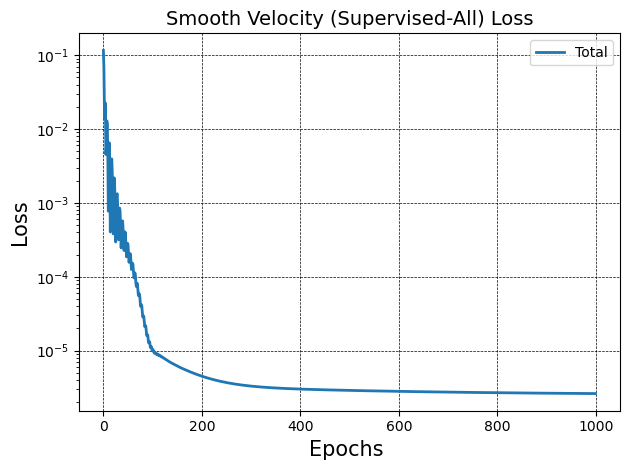

In [40]:
# Plotting the Loss Curve
plt.semilogy(Loss_f, label="Total", linewidth=2) # Plots the total loss

plt.title("Smooth Velocity (Supervised-All) Loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.tight_layout()

%mkdir figs
plt.savefig("./figs/Smooth Velocity (Supervised-All) Loss.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saves the figure
plt.savefig("./figs/Smooth Velocity (Supervised-All) Loss.png", format="png", bbox_inches="tight", dpi=300)

plt.show() # Displays the figure

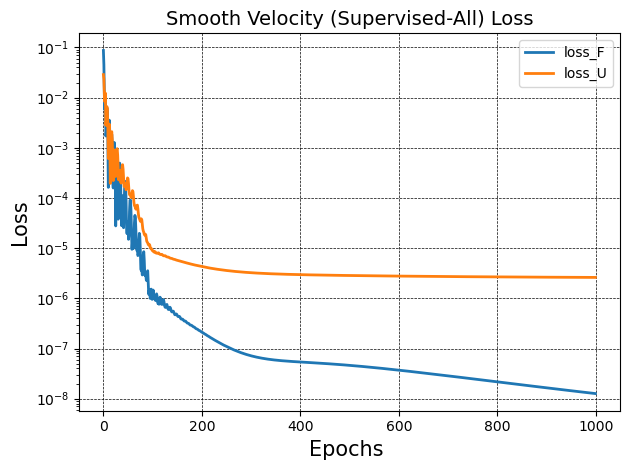

In [41]:
# Plotting the Loss Curve
plt.semilogy(loss_F, label="loss_F", linewidth=2) # Plots the total loss
plt.semilogy(loss_U, label="loss_U", linewidth=2) # Plots the total loss

plt.title("Smooth Velocity (Supervised-All) Loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.tight_layout()

plt.savefig("./figs/Smooth Velocity (Supervised-Sperate) Loss.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saves the figure
plt.savefig("./figs/Smooth Velocity (Supervised-Sperate) Loss.png", format="png", bbox_inches="tight", dpi=300)

plt.show() # Displays the figure

In [42]:
model_input = torch.stack((x_p, z_p), axis = 1)

pred_tau = model(model_input).detach().numpy()

pred_tau=pred_tau.reshape(Z.shape).T

T_pred = -1*pred_tau*T0
T_pred = T_pred.T

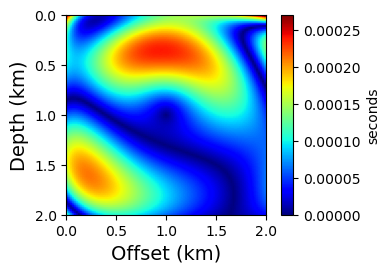

In [43]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)
plt.tight_layout()

plt.savefig("./figs/pinnerror.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/pinnerror.png", format='png', bbox_inches="tight", dpi=300)

In [44]:
# Load fast sweeping traveltims for comparison

T_fsm = np.load('./input/Tcomp.npy')

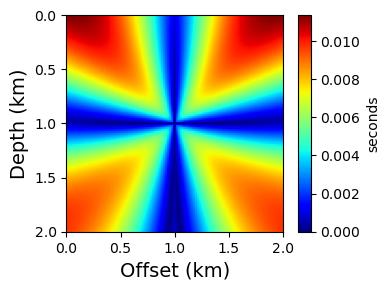

In [45]:
# Plot the first order FSM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)
plt.tight_layout()

plt.savefig("./figs/fsmerror.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fsmerror.png", format='png', bbox_inches="tight", dpi=300)

/tmp/ipykernel_528472/3218873367.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_ignches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./figs/contours.pdf", format='pdf', bbox_ignches="tight", dpi=300)
/tmp/ipykernel_528472/3218873367.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_ignches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./figs/contours.png", format='png', bbox_ignches="tight", dpi=300)


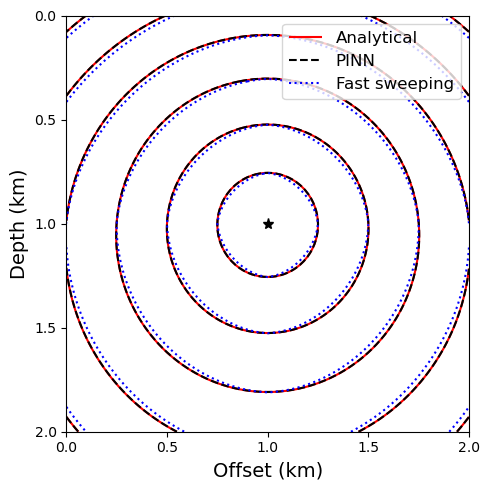

In [46]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.savefig("./figs/contours.pdf", format='pdf', bbox_ignches="tight", dpi=300)
plt.savefig("./figs/contours.png", format='png', bbox_ignches="tight", dpi=300)

In [47]:
# Determining the accuracy of the model by quantifying the difference between T_pred and T_data using Vector Norm
print(np.linalg.norm(T_pred-T_data)/np.linalg.norm(T_data))
print(np.linalg.norm(T_pred-T_data))

0.0003441918824345679
0.01155916544220444


In [48]:
# RMAE comparison of two different methods
print("RMAE of Fast Sweeping =", 100 * abs(T_fsm - T_data).mean() / T_data.mean(), '%')
print("RMAE of PINNeik =", 100 * abs(T_pred - T_data).mean() / T_data.mean(), '%')

RMAE of Fast Sweeping = 1.9347973475396012 %
RMAE of PINNeik = 0.030489997249293452 %
